# How likely is a patient to get pregnant with fertility treatment ?

In [13]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


## Introduction

**Business Context.** A new fertility treatment emerged that dramatically improved pregnancy rate in women struggling with infertility. While most patients succeeded in getting pregnant, some failed due to complications of various clinical factors. A study gathered pregnancy outcome and clinic characteristics of around 900 inferitlity patients who have undergone this treatment.

**Business Problem.** Your task is to **build a model to predict how likely is a patient who goes through this new feritility treatment to have a successful pregnancy**.

**Analytical Context.** The dataset consists of treatment cycles of a patient. A patient can go through multiple treatment cycles until getting a successful pregnancy, while other patients will never get a successful pregnancy. There are two types of treatment cycles: 
- Primary Cycle: regular treatment cycle
- Sub_Cycle: a subsidiary treatment cycle that takes place sometimes when the initial phase of the primary cycle failes. Each Sub_Cycle should be considered part of the Primary Cycle that precedes it in the cycle date.

**Case Studied.** The following cases need to be completed:

1. Build the column Pregnancy which equals the treatment outcome for each patient. If more sub_cycles exist for a patient, the outcome will be equal to the outcome of the last sub_cycle. The manipulated dataset would only have rows with record type "Primary_Cycle", and a newly added "Pregnancy" column.  
2. Compute the per-cycle pregnancy rates for the training set and the testing set. Compute the weighted pregnancy rates per patient in the training set and testing set.    
3. Build a machine learning model to predict which patient will have an ultimate live birth after treatment.   
4. What is the outcome of the model ?  
5. Assume that fertility treatment is completed in different stages. Some metrics are available as the patient walks in for consultation, but some are available after certain stages are completed. Identify important features in the analysis and their impact on the model.

## Data exploration

Let's start by taking a look at the available data:

1. **ID**: patient Identification number
2. **Record Type**: the type of cycle
3. **Initial Outcome**: the outcome of the cycle
4. **cycle_date**: the date of the cycle
5. **Feature_1**: float
6. **Feature_2**: float
7. **Feature_3**: float
8. **Feature_4**: float
9. **Feature_5**: float
10. **Feature_6**: integer from 0 to a maximum value
11. **Feature_7**: integer from 0 to a maximum value
12. **Feature_8**: integer from 0 to a maximum value
13. **Feature_9**: integer from 0 to a maximum value
14. **Feature_10**: integer from 0 to a maximum value
15. **Feature_11**: integer from 0 to a maximum value
16. **Feature_12**: boolean
17. **Feature_13**: boolean
18. **Feature_14**: boolean
19. **Feature_15**: boolean
20. **Feature_16**: boolean

In [58]:
dataTrain = pd.read_csv("/Users/ioana/Desktop/Documents/train_final.csv")
dataTrain.head()

,ID,Record_Type,initial_outcome,cycle_date,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16
0,1,Primary_Cycle,livebirth,7/21/15,-1.466825,1.728360,0.409782,-0.530135,0.280268,5,1,1,0,1,1,False,False,False,False,False
1,2,Primary_Cycle,preg_none,3/3/15,0.168383,-0.951851,0.690648,-0.314687,3.650835,0,0,0,0,1,1,False,False,False,False,False
2,2,Primary_Cycle,livebirth,7/22/15,0.401985,-0.951851,0.690648,-0.314687,3.650835,0,0,0,0,2,2,False,False,False,False,False
3,3,Primary_Cycle,preg_none,9/7/16,1.336390,-0.807295,0.821151,-0.314687,0.628947,0,0,0,0,2,2,True,False,False,True,False
4,3,Sub_Cycle,livebirth,10/24/16,1.336390,-0.807295,-0.645594,-0.314687,0.628947,0,0,0,0,0,0,True,False,False,True,False


Let's check if there is any missing data:

In [78]:
dataTrain.shape

(932, 20)

### Case 1: Data Manipulation
Below is shown the manipulation of the data to only keep the outcome of the last cycle, while having this output in the 'Pregnancy' new column.

In [52]:
def processData(data):
    # read the columns and rows
    columnsN = data.head()
    Nrows = data[columnsN.columns[1]].count()

    '''Create a new data frame and keep only the last cycles (primary or sub-cycle)'''
    ### optimization : try parameters.drop() to substitute creating the new dataframe
    newDF = pd.DataFrame(columns = columnsN.columns)
    for i in range(Nrows):
        if i < Nrows-1:
            if data.loc[i+1]['Record_Type'] == 'Primary_Cycle':
                newDF = newDF.append(data.loc[i])
            elif data.loc[i+1]['Record_Type'] == 'Sub_Cycle':
                continue
        else:
            newDF = newDF.append(data.loc[i])

    '''modify data frame look (row name, column name etc)'''
    newDF.insert(4,'Pregnancy',newDF['initial_outcome'],True)
    newDF['Record_Type'] = newDF['Record_Type'].replace(['Sub_Cycle'],'Primary_Cycle')
    newDF = newDF.drop(['initial_outcome'], axis = 1)
    return newDF

dataTrainP = processData(dataTrain)
dataTrainP.head()

,ID,Record_Type,cycle_date,Pregnancy,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16
0,1,Primary_Cycle,7/21/15,livebirth,-1.466825,1.728360,0.409782,-0.530135,0.280268,5,1,1,0,1,1,False,False,False,False,False
1,2,Primary_Cycle,3/3/15,preg_none,0.168383,-0.951851,0.690648,-0.314687,3.650835,0,0,0,0,1,1,False,False,False,False,False
2,2,Primary_Cycle,7/22/15,livebirth,0.401985,-0.951851,0.690648,-0.314687,3.650835,0,0,0,0,2,2,False,False,False,False,False
4,3,Primary_Cycle,10/24/16,livebirth,1.336390,-0.807295,-0.645594,-0.314687,0.628947,0,0,0,0,0,0,True,False,False,True,False
5,9,Primary_Cycle,1/8/15,livebirth,0.635586,-0.203568,-0.489558,-0.530135,-0.533318,0,0,0,0,1,1,True,False,False,False,False


The categorical features (e.g. 'Pregnancy') can be changes to numerical. The same can be done for the boolean features (e.g. 'Feature_12' to 'Feature_16') in order to use them inside the machine learning model as normal numerical features.

In [55]:
def datatoIntMapping(newDF):
    '''Changing the string features to integers for data preparation for ML algorithms'''
    colNames = newDF.head().columns
    for c in colNames:
        if c.find('Feature') != -1:
            newDF[c] *= 1
    newDF['Pregnancy'] = newDF['Pregnancy'].replace(['livebirth'],'1')
    newDF['Pregnancy'] = newDF['Pregnancy'].replace(['preg_none'],'0')
    return newDF

dataTrainP = processData(dataTrain)
dataTrainML = datatoIntMapping(dataTrainP)
dataTrainML.head()

,ID,Record_Type,cycle_date,Pregnancy,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16
0,1,Primary_Cycle,7/21/15,1,-1.466825,1.728360,0.409782,-0.530135,0.280268,5,1,1,0,1,1,0,0,0,0,0
1,2,Primary_Cycle,3/3/15,0,0.168383,-0.951851,0.690648,-0.314687,3.650835,0,0,0,0,1,1,0,0,0,0,0
2,2,Primary_Cycle,7/22/15,1,0.401985,-0.951851,0.690648,-0.314687,3.650835,0,0,0,0,2,2,0,0,0,0,0
4,3,Primary_Cycle,10/24/16,1,1.336390,-0.807295,-0.645594,-0.314687,0.628947,0,0,0,0,0,0,1,0,0,1,0
5,9,Primary_Cycle,1/8/15,1,0.635586,-0.203568,-0.489558,-0.530135,-0.533318,0,0,0,0,1,1,1,0,0,0,0


In [79]:
dataTrainML.shape

(613, 20)

#### Data Visualization

a) Distribution Plots

We can visualize each feature in order to understand better the data and its impact on the outcome of the treatment cycle. 
As an example, we can observe that higher values of Feature_5 favors a successful outcome of the fertility treatment. 

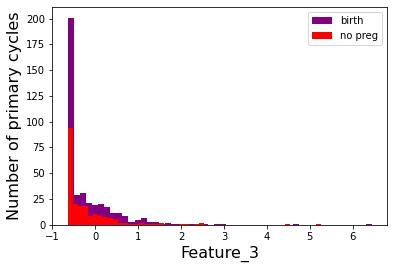

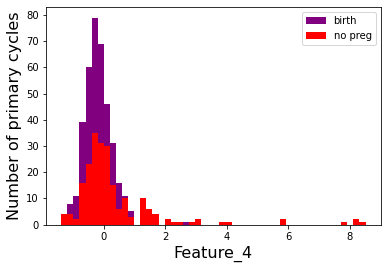

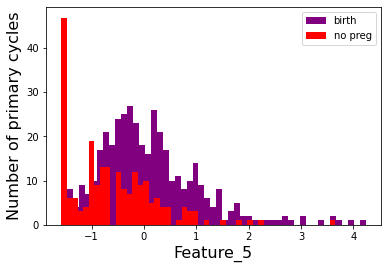

In [56]:
def plotFeatures(data_dframe,f1):
    feat1 = str(f1)
    #separate features vs class
    df_birth = data_dframe[data_dframe['Pregnancy']=='1']
    df_no_preg = data_dframe[data_dframe['Pregnancy']=='0']
    #plot features vs class
    fig,ax = plt.subplots()
    bval,bins,patches = plt.hist(df_birth[feat1].astype(float),bins = 50,facecolor="purple",label='birth')
    bval,bins,patches = plt.hist(df_no_preg[feat1].astype(float),bins = 50,facecolor="red",label='no preg')
    ax.legend()
    plt.xlabel(feat1,fontsize = 16)
    plt.ylabel('Number of primary cycles',fontsize = 16)
    #plt.savefig('plot_'+feat1+'.png')
    
featList = ['Feature_3','Feature_4','Feature_5']
for i in range(len(featList)):
        plotFeatures(dataTrainML,featList[i])
        #plt.close("all")

b) Scattered Plots

We can also look for possible correlations between features using the scattered plots, as shown below. For each scattered plot, one can look for a phase space decribed by the two corresponding features in which the successful pregnancy dominates. This can then be interpreted as a correlation between these features. 

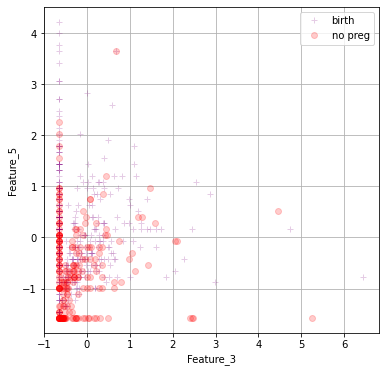

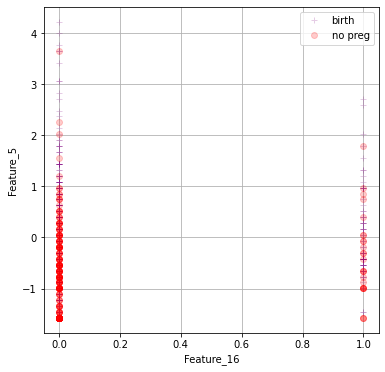

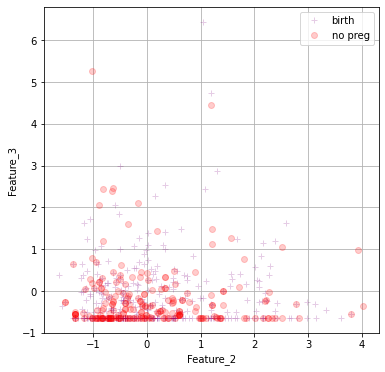

In [57]:
def plotFeaturesvsPreg(data_dframe,f1,f2):
    fig = plt.figure(figsize=(6,6))
    main_ax = fig.add_subplot()
    feat1 = str(f1)
    feat2 = str(f2)
    #separate features vs class
    df_birth = data_dframe[data_dframe['Pregnancy']=='1']
    df_no_preg = data_dframe[data_dframe['Pregnancy']=='0']
    #plot features vs class
    main_ax.plot(df_birth[feat1].astype(float),df_birth[feat2].astype(float),'ok', marker='+',markersize=6,alpha=0.2,color="purple",label='birth')
    main_ax.plot(df_no_preg[feat1].astype(float),df_no_preg[feat2].astype(float),'ok', marker='o',markersize=6,alpha=0.2,color="red",label='no preg')
    main_ax.grid(True)
    main_ax.set_ylabel(feat2)
    main_ax.set_xlabel(feat1)
    main_ax.legend()
    #fig.savefig('pregOutcome_for_'+feat1+'vs'+feat2+'.png')
plotFeaturesvsPreg(dataTrainML,'Feature_3','Feature_5')
plotFeaturesvsPreg(dataTrainML,'Feature_16','Feature_5')
plotFeaturesvsPreg(dataTrainML,'Feature_2','Feature_3')

## Data Analysis

### Case 2: Rates in Data

In order to compute the pregnancy rates for both training and testing data sets, we would like to also process the testing dataset, following the same procedure used in Case 1 for the training dataset.
For testing dataset, the dataframe table would look as following: 

In [72]:
## process the testing dataset
dataTest = pd.read_csv("/Users/ioana/Desktop/Documents/test_final.csv")
dataTest.shape

(490, 20)

In [76]:
dataTestP = processData(dataTest)
dataTestML = datatoIntMapping(dataTestP)
dataTestML.shape

(314, 20)

In [77]:
dataTestML.head()

,ID,Record_Type,cycle_date,Pregnancy,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16
1,4,Primary_Cycle,5/6/15,1,1.102789,1.750034,-0.645594,-0.530135,0.280268,0,0,0,0,0,0,0,0,0,0,0
3,5,Primary_Cycle,8/18/16,1,-0.999623,-0.496205,-0.645594,-0.314687,1.791212,5,4,1,0,0,0,0,0,0,0,0
4,6,Primary_Cycle,5/17/15,0,1.569991,0.403293,-0.478209,0.547104,-1.579356,3,1,0,0,1,1,1,0,1,0,0
5,6,Primary_Cycle,6/11/15,1,1.569991,0.403293,-0.478209,0.547104,-1.114450,3,1,0,0,2,2,1,0,1,0,0
8,7,Primary_Cycle,9/13/16,1,-0.065218,0.619198,-0.645594,-0.530135,1.558759,2,2,0,1,0,0,0,0,0,0,0


The successful pregnancy rates per-cycle are computed below:

In [66]:
def pregRatePerCycle(datadf):
        '''Compute pregnancy rates pre cycle'''
        liveB = datadf[datadf['Pregnancy'] == '1']['Pregnancy'].count()
        nopreg = datadf[datadf['Pregnancy'] == '0']['Pregnancy'].count()
        pregnancyRate_perCycle = liveB/(liveB+nopreg)
        return pregnancyRate_perCycle
print('Pregnancy rate per cycle for Training Dataset = ',pregRatePerCycle(dataTrainML))
print('Pregnancy rate per cycle for Test Dataset = ',pregRatePerCycle(dataTestML))

Pregnancy rate per cycle for Training Dataset =  0.6508972267536705
Pregnancy rate per cycle for Test Dataset =  0.6528662420382165


The weighted pregnancy rates per patient are computed below:

In [69]:
def weightedPregRatePerPatient(datadf):
        '''Compute pregnancy rates per patient'''
        uniqueID = datadf['ID'].unique()
        countID = []
        liveBid = []
        for i in uniqueID:
            countID.append(datadf[datadf['ID'] == i]['ID'].count())
            datadf2 = datadf[datadf['ID'] == i]
            datadf3 = datadf2[datadf2['Pregnancy'] == '1']
            liveBid.append(datadf3['ID'].count())
            #liveBid.append(datadf[datadf['ID'] == i][datadf['Pregnancy'] == '1']['ID'].count())
        weight_per_ID = []
        for c in range(len(countID)):
            weight_per_ID.append(liveBid[c]/countID[c]*1.0)
        pregnancyRate_perPatient_weighted = sum(weight_per_ID)/len(weight_per_ID)
        return pregnancyRate_perPatient_weighted
print('Weighted pregnancy rate per patient for Training Dataset = ',weightedPregRatePerPatient(dataTrainML))
print('Weighted pregnancy rate per patient for Test Dataset = ',weightedPregRatePerPatient(dataTestML))

Weighted pregnancy rate per patient for Training Dataset =  0.7404210526315789
Weighted pregnancy rate per patient for Test Dataset =  0.7378048780487805


### Case 3: Machine Learning Model

#### Choosing the Machine Learning Model

I considered the problem to be a classification problem  with relatively small number of features and a fair number of examples. I expect that some non-sophisticated classification algorithms like SVM or Logistic Regression would provide a good result. 
I used two different approaches for the Machine Learning models:

1. Build the Machine Learning algorithm (logistic regression) from scratch 
2. Use Scikit_learn library: SVC and Logistic Regression 

##### Preparing the matrices: X,y
The X, y matrices (input data) are computed into the xyMatrices(). The code is writted in such a way that a subset of features can be used instead of the all the available ones. 

Feature scaing is probably not necessary since there is no big difference betwenn feature ranges.

In [134]:
def xyMatrices(noFeat):
    #preparing the matrix for the training set (used to train the model)
    #"noFeat" - represent the features to be removed from matrix X
    y_read = np.array(dataTrainML['Pregnancy'])
    y = y_read.astype(np.int)
    m = len(y)
    features = dataTrainML.head().columns[4:]
    excludeFeat =np.array(noFeat)
    features = features[np.logical_not(np.isin(features,excludeFeat))]
    n = len(features)
    #print(features)
    x_read = dataTrainML[features].values
    x = x_read.astype(np.float)

    #preparing the matrix for the testing set (used to only test/validate the model)
    yt = np.array(dataTestML['Pregnancy'])
    y_true = yt.astype(np.int)
    xt = dataTestML[features].values
    x_test = xt.astype(np.float)
    
    return x,y,x_test,y_true,m,n

noFeatures = []
x,y,x_test,y_true,m,n = xyMatrices(noFeatures)
print('X = ', x)
print('y = ', y)
print('number of features = ', n)
print('number of examples used in training set = ', m)
print('x_test = ', x_test)
print('y_true = ', y_true)

X =  [[-1.46682536  1.72835982  0.40978154 ...  0.          0.
   0.        ]
 [ 0.16838347 -0.95185052  0.69064771 ...  0.          0.
   0.        ]
 [ 0.40198473 -0.95185052  0.69064771 ...  0.          0.
   0.        ]
 ...
 [-0.99962284 -0.88376732 -0.64559436 ...  0.          0.
   1.        ]
 [ 1.56999103 -0.44023685 -0.04130655 ...  1.          0.
   0.        ]
 [ 1.56999103 -0.44023685 -0.04130655 ...  1.          0.
   0.        ]]
y =  [1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1
 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1
 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1
 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1
 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1
 1 0 0 1 1 1 0 0 1 1 

##### 1. Build the Machine Learning Algorithm from scratch

I chose the Logistic Regression algorithm, to which I applied regularization. I rtied adjusting some parameters in order to obtain reasonable accuracy and AUC. The main implementation is done into customLogisticRegression() function, while the weights #\theta# are computed into computeTheta() function.

The following parameters are used within the logistic regression algorithm:
1. Niter - the maximum number of iterations allowed to minimize the cost function.
2. alpha - learning rate
3. lmda - regularization parameter
4. epsilon - the value below which any hange in the cost function is considered negligible
5. threshold - the threshold which delimitates the two classes (e.g. successful pregnancy and no pregnancy) in the predicted output 

The cost function as the number of iterations is plotted in order to check for the convergence of the algorithm. 

Logistic Regression custom - weights:  [[ 0.85985875]
 [ 0.10438116]
 [ 0.25701981]
 [-0.02669708]
 [ 0.68758354]
 [-0.06341822]
 [ 0.19985038]
 [ 0.17987336]
 [ 0.13543652]
 [ 0.00394325]
 [ 0.0059025 ]
 [ 0.14833776]
 [ 0.36560059]
 [ 0.28549251]
 [ 0.39395472]
 [ 0.4365294 ]]
Logistic Regression custom - AUC score =  0.5659431640187962
Logistic Regression custom - accuracy_score =  0.5318471337579618
Logistic Regression custom - precision_score =  0.7071428571428572
Logistic Regression custom - f1_score =  0.5739130434782608


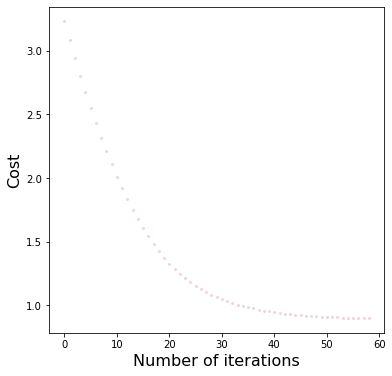

In [135]:
def plotCost(cost):
        iteration = [i for i in range(len(cost))]
        #fig,ax = plt.subplots()
        fig = plt.figure(figsize=(6,6))
        main_ax = fig.add_subplot()
        main_ax.plot(iteration,cost, 'ok', markersize=2, alpha=0.2, color="indianred")
        #bval,bins,patches = ax.hist(iteration,cost,facecolor='indianred',edgecolor='indianred',label='Cost')
        main_ax.set_xlabel('Number of iterations',fontsize = 16)
        main_ax.set_ylabel('Cost',fontsize = 16)
        fig.savefig('Cost_logisticRegression.png')

def computeSigmoid(theta,x_matrix):
        thetaT = theta.reshape(-1,1)
        h = 1/(1+np.exp(-1*np.matmul(x_matrix,thetaT)))
        return h

def computeThetas(theta,alpha):
        h = computeSigmoid(theta,x)
        hminy = 0
        hminyx = np.zeros(n)
        loghSum = 0

        for i in range(1,m):
            hminy += h[i][0]-y[i]
            loghSum += y[i]*np.log(h[i][0]) + (1-y[i])*np.log(1-h[i][0])
            for j in range(1,n):
                hminyx[j] += (h[i][0]-y[i])*x[i][j]

        theta[0] = theta[0] - alpha*(1/m)*hminy
        for j in range(1,n):
            theta[j] = theta[j]*(1-(alpha*lmda/m)) - alpha*(1/m)*hminyx[j]

        newth = np.array(theta)
        #print('---------loghSum = ',loghSum)
        return newth,loghSum

def customLogisticRegression(Niter,alpha,lmda,epsilon,threshold):
        theta = np.ones(n)
        computeThetas(theta,alpha)

        cost = []
        for i in range(Niter):
            newtheta,loghSum = computeThetas(theta,alpha)
            #print(loghSum)
            cost.append((-1/m)*loghSum+((lmda/(2*m))*sum(pow(newtheta,2))))
            #print(cost)
            theta = newtheta
            if i > 0 and abs(cost[i]-cost[i-1]) < epsilon:
                break
        plotCost(cost)
        theta_logisticR = np.array(theta).reshape(-1,1)
        print("Logistic Regression custom - weights: ", theta_logisticR)
        hypoth = computeSigmoid(theta_logisticR,x_test)
        #compare this to null error and accuracy from Scikit
        print('Logistic Regression custom - AUC score = ',roc_auc_score(y_true,hypoth))
        y_predict = (hypoth > threshold).astype(int)
        print('Logistic Regression custom - accuracy_score = ',accuracy_score(y_true,y_predict))
        print('Logistic Regression custom - precision_score = ',precision_score(y_true,y_predict))
        print('Logistic Regression custom - f1_score = ',f1_score(y_true,y_predict))
        
Niter = 1000
alpha = 0.1
lmda = 100.0
epsilon = 0.0001
threshold = 0.6
customLogisticRegression(Niter,alpha,lmda,epsilon,threshold)


##### 2. Train the Logistic Regression model from Scikit_learn
First, the Logistic Regression model from Scikit learn was used as the training algorithm using Training Dataset. Next, the trained model was used to predict values from the Test Dataset. 

In [136]:
model = LogisticRegression(C=10).fit(x,y)
print('LogR: Scikit model - score = ',model.score(x,y))
print('LogR: Scikit null error (mean) = ',y.mean())
print('LogR: Scikit model - thetas = [',model.intercept_,', ',model.coef_,']')
#compare the prediction to the true
print('LogR: AUC score = ',roc_auc_score(y_true, model.predict(x_test)))
print('LogR: accuracy_score = ',accuracy_score(y_true,model.predict(x_test)))
print('LogR: precision_score = ',precision_score(y_true,model.predict(x_test)))
print('LogR: f1_score = ',f1_score(y_true,model.predict(x_test)))

LogR: Scikit model - score =  0.7112561174551386
LogR: Scikit null error (mean) =  0.6508972267536705
LogR: Scikit model - thetas = [ [1.23108178] ,  [[-0.20939307  0.01548973 -0.17643729 -0.10808475  0.84553122 -0.13146405
   0.13131344  0.19720893 -0.27105883 -0.0399368  -0.08564274 -0.29325937
   0.01907058 -0.14880054  0.487247    0.03111953]] ]
LogR: AUC score =  0.6619377936898634
LogR: accuracy_score =  0.732484076433121
LogR: precision_score =  0.746938775510204
LogR: f1_score =  0.8133333333333334


##### 3. Train the SVC model from Scikit_learn
First, the Logistic Regression model from Scikit learn was used as the training algorithm using Training Dataset. I used the Gaussian Kernel (rbf) and gamma = 1 / (n_features * X.var()). The penalty C is = 1.
Next, the trained model was used to predict values from the Test Dataset.

In [137]:
model = SVC(kernel='rbf',gamma = 'scale',C=1.0).fit(x,y)
print('SVC: Scikit model - score = ',model.score(x,y))
#compare the prediction to the true
print('SVC: AUC score = ',roc_auc_score(y_true, model.predict(x_test)))
print('SVC: accuracy_score = ',accuracy_score(y_true,model.predict(x_test)))
print('SVC: precision_score = ',precision_score(y_true,model.predict(x_test)))
print('SVC: f1_score = ',f1_score(y_true,model.predict(x_test)))

SVC: Scikit model - score =  0.7748776508972267
SVC: AUC score =  0.6447527411053927
SVC: accuracy_score =  0.732484076433121
SVC: precision_score =  0.7318007662835249
SVC: f1_score =  0.8197424892703863


### Case 4 : Results

The results of each trained Machine Learning model are shown above. Here are a few highlights:
- the best AUC value is obtianed from the Logistic Regression model (Scikit_learn) after tuning C=1/lambda. The value is AUC= 0.661 which compared to the null error = 0.651 is only slightly better.This might be due to the fact that the data is slightly unbalanced. 
- the F1 score is fairly good for both Logistic Regression and SVC. This might be due to the fact that F1_score is not that sensitive to the unbalanced data.
- more training is needed for custom Logistic Regression algorithm in order to have a performance comparable to the Scikit_learn algorithms.
- other algorithms (e.g. Random Forest) might perform better with the unbalanced data.

### Case 5 : Dealing with missing important features 

In order to identify important features in our data, we can look at both their distributions and the weights computed by the trained models.
In our case, we could observe that by looking at the feature weights from the Logistic Regression algorithm, we can see that the biggest weight is assigned to 'Feature_5' (= 0.845). This is in agreement with our earlier observation from the distribution and scattered plots. Below are the weights for all features, from 'Feature_1' to 'Feature_16'
[-0.20939307  0.01548973 -0.17643729 -0.10808475  0.84553122 -0.13146405
   0.13131344  0.19720893 -0.27105883 -0.0399368  -0.08564274 -0.29325937
   0.01907058 -0.14880054  0.487247    0.03111953]
'Feature_15' could also be significat, since its weight is = 0.487.

#### What happens if an important feature(s) is missing ?

Once the important features are identified, we can train the Machine Learning Models without them (or without some of them).

Let's look at one example. Assume we would exclude 'Feature_5' from the model. We retrain the models without the specified features and compare the new predictions to the ones obtained with all the features. 

In [140]:
# build the X,y matrices without specified freatures
noFeatures = ['Feature_5']
x,y,x_test,y_true,m,n = xyMatrices(noFeatures)
print('X = ', x)
print('y = ', y)
print('number of features = ', n)
print('number of examples used in training set = ', m)
print('x_test = ', x_test)
print('y_true = ', y_true)

X =  [[-1.46682536  1.72835982  0.40978154 ...  0.          0.
   0.        ]
 [ 0.16838347 -0.95185052  0.69064771 ...  0.          0.
   0.        ]
 [ 0.40198473 -0.95185052  0.69064771 ...  0.          0.
   0.        ]
 ...
 [-0.99962284 -0.88376732 -0.64559436 ...  0.          0.
   1.        ]
 [ 1.56999103 -0.44023685 -0.04130655 ...  1.          0.
   0.        ]
 [ 1.56999103 -0.44023685 -0.04130655 ...  1.          0.
   0.        ]]
y =  [1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1
 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1
 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1
 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1
 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1
 1 0 0 1 1 1 0 0 1 1 

In [141]:
#Logistic Regression (without 'Feature_5')
model = LogisticRegression(C=10).fit(x,y)
print('LogR: Scikit model - score = ',model.score(x,y))
print('LogR: Scikit null error (mean) = ',y.mean())
print('LogR: Scikit model - thetas = [',model.intercept_,', ',model.coef_,']')
#compare the prediction to the true
print('LogR: AUC score = ',roc_auc_score(y_true, model.predict(x_test)))
print('LogR: accuracy_score = ',accuracy_score(y_true,model.predict(x_test)))
print('LogR: precision_score = ',precision_score(y_true,model.predict(x_test)))
print('LogR: f1_score = ',f1_score(y_true,model.predict(x_test)))

LogR: Scikit model - score =  0.6851549755301795
LogR: Scikit null error (mean) =  0.6508972267536705
LogR: Scikit model - thetas = [ [1.36373795] ,  [[-0.24084388  0.02049736 -0.14470105 -0.21848951 -0.12543103  0.11876016
   0.12934392 -0.21992559 -0.33536438  0.01254927 -0.62850286 -0.30292274
  -0.28431744  0.10417329 -0.12892146]] ]
LogR: AUC score =  0.5842470351309017
LogR: accuracy_score =  0.6815286624203821
LogR: precision_score =  0.6981132075471698
LogR: f1_score =  0.7872340425531914


In [142]:
#SVM (without 'Feature_5')
model = SVC(kernel='rbf',gamma = 'scale',C=1.0).fit(x,y)
print('SVC: Scikit model - score = ',model.score(x,y))
#compare the prediction to the true
print('SVC: AUC score = ',roc_auc_score(y_true, model.predict(x_test)))
print('SVC: accuracy_score = ',accuracy_score(y_true,model.predict(x_test)))
print('SVC: precision_score = ',precision_score(y_true,model.predict(x_test)))
print('SVC: f1_score = ',f1_score(y_true,model.predict(x_test)))

SVC: Scikit model - score =  0.7422512234910277
SVC: AUC score =  0.5551577534123966
SVC: accuracy_score =  0.6687898089171974
SVC: precision_score =  0.6810035842293907
SVC: f1_score =  0.7851239669421488


##### Results for predictions using data without 'Feature_5'

By comparing the prediction results obtained with and without 'Feature_5', we can see the following:

- AUC score decrease by 10%, from 0.65 to 0.55 when 'Feature_5' is not available. 
- Accuracy also decresed by 7-8%, from 0.73 to 0.66 when 'Feature_5' is not available. 
- F1 score is also lower by 3%, from 0.81 to 0.78 when 'Feature_5' is not available.
- The model results are pulled now by 'Feature_12', which did not seem very significat when 'Feature_5' was present. A possible correlation between 'Feature_5' and 'Feature_12' might be interesting to be investigated.